In [1]:
import pandas as pd
import glob
import os

## Data Ingestion

I began by importing and combining multiple Kickstarter CSVs I scraped from the web. Each file contains campaign-level data, and merging them gives me a single dataset with over 160,000 rows. This will form the basis for my exploratory analysis and modeling.

In [2]:
folder_path = os.path.expanduser("~/Downloads/Kickstarter_2025-03-12T07_34_02_656Z")
all_csv_files = glob.glob(os.path.join(folder_path, "Kickstarter*.csv"))

In [3]:
df_list = [pd.read_csv(file) for file in all_csv_files]
df = pd.concat(df_list, ignore_index=True)

In [4]:
print(f"Combined dataset shape: {df.shape}")
df.head()

Combined dataset shape: (160938, 42)


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,video
0,16,Berkeley Spark is a Burning Man-inspired festi...,"{""id"":53,""name"":""Public Art"",""analytics_name"":...",1527.0,US,the United States,1373915734,"{""id"":998722984,""name"":""Downtown Berkeley Asso...",USD,$,...,True,False,successful,1377221919,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1.000000,1527.000000,domestic,"{""id"":267221,""status"":""successful"",""hls"":null,..."
1,96,The ATSA Everyday® ESK8 Skateboard Backpack le...,"{""id"":263,""name"":""Apparel"",""analytics_name"":""A...",18217.0,NL,the Netherlands,1602162266,"{""id"":85115145,""name"":""ATSA Skateboard Backpac...",EUR,€,...,True,False,successful,1614001879,1.218811,"{""web"":{""project"":""https://www.kickstarter.com...",1.212065,18318.723919,domestic,NaN
2,1,"Create your WINION! Personalize it, train it a...","{""id"":272,""name"":""Mobile Games"",""analytics_nam...",1.0,ES,Spain,1455617503,"{""id"":767807920,""name"":""Krask"",""is_registered""...",EUR,€,...,False,False,failed,1458492171,1.113918,"{""web"":{""project"":""https://www.kickstarter.com...",1.126974,1.113918,domestic,"{""id"":638459,""status"":""successful"",""hls"":null,..."
3,0,"Un nuovo concetto, un nuovo design integrando ...","{""id"":356,""name"":""Woodworking"",""analytics_name...",0.0,IT,Italy,1739893557,"{""id"":59701947,""name"":""AESTHETIC-LAB"",""is_regi...",EUR,€,...,False,False,live,1739896283,1.049555,"{""web"":{""project"":""https://www.kickstarter.com...",1.089754,0.000000,domestic,NaN
4,1,"The app involves photography, travel, competit...","{""id"":272,""name"":""Mobile Games"",""analytics_nam...",0.0,NZ,New Zealand,1453763850,"{""id"":1969747683,""name"":""Sam Baldock"",""is_regi...",NZD,$,...,False,False,failed,1455582489,0.649111,"{""web"":{""project"":""https://www.kickstarter.com...",0.665422,0.649111,domestic,NaN


## Basic Cleaning and Filtering

I dropped duplicate rows and filtered out campaigns with nonpositive funding goals. These entries are likely errors or incomplete drafts and could skew the modeling process.

In [5]:
df = df.drop_duplicates()
df = df[df['goal'] > 0]

In [6]:
df["state"].value_counts()

state
successful    86751
failed        53050
canceled       6402
live           5189
started         873
suspended         7
Name: count, dtype: int64

Most campaigns either succeed or fail, with everything else making up a tiny fraction.

## Defining Success

I created a new binary variable called `successful`, where campaigns marked as "successful" remain 1, and all other outcomes (failed, canceled, etc.) are coded as 0. This simplification makes it easier to frame the problem as a binary classification task.

In [7]:
df['successful'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

In [8]:
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 blurb                                     21
converted_pledged_amount                 880
is_in_post_campaign_pledging_phase    113940
location                                 162
usd_exchange_rate                        880
usd_pledged                              880
usd_type                                  12
video                                  54373
dtype: int64


## Missing Data Overview

Some columns had a large amount of missing data especially `video` and `is_in_post_campaign_pledging_phase`. Since these aren't central to my analysis and would introduce noise, I dropped them. For smaller gaps like in `location`, I used simple imputations.

In [9]:
df_clean = df.drop(columns=['video', 'is_in_post_campaign_pledging_phase'])
df_clean['location'] = df_clean['location'].fillna("Unknown")

In [10]:
df_clean["location"].head()

0    {"id":2362930,"name":"Berkeley","slug":"berkel...
1    {"id":727232,"name":"Amsterdam","slug":"amster...
2    {"id":753692,"name":"Barcelona","slug":"barcel...
3    {"id":20150549,"name":"Italia","slug":"italia-...
4    {"id":2351310,"name":"Wellington","slug":"well...
Name: location, dtype: object

## Location Processing

The `location` column is stored as a JSON string. I parsed this to extract city, state, country, and a readable full name. This will help in future geographic breakdowns or exploratory visualizations.

In [11]:
import json

def extract_location_info(loc_json):
    try:
        loc = json.loads(loc_json)
        return pd.Series({
            'city': loc.get('name', 'Unknown'),
            'state': loc.get('state', 'Unknown'),
            'country': loc.get('country', 'Unknown'),
            'full_name': loc.get('displayable_name', 'Unknown')
        })
    except (json.JSONDecodeError, TypeError):
        return pd.Series({
            'city': 'Unknown',
            'state': 'Unknown',
            'country': 'Unknown',
            'full_name': 'Unknown'
        })

df_clean[['city', 'state', 'country', 'full_location']] = df_clean['location'].apply(extract_location_info)

In [12]:
df_clean.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_disliked', 'is_launched', 'is_liked', 'is_starrable',
       'launched_at', 'location', 'name', 'percent_funded', 'photo', 'pledged',
       'prelaunch_activated', 'profile', 'slug', 'source_url', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls',
       'usd_exchange_rate', 'usd_pledged', 'usd_type', 'successful', 'city',
       'full_location'],
      dtype='object')

## Campaign Duration Calculation

Kickstarter campaigns include launch and deadline timestamps (in Unix format). I converted these to datetime and calculated `duration_days`, a new feature capturing how long a campaign lasted. Kickstarter recommends 30-day campaigns, so this might be a useful predictor.

## Preventing Data Leakage

To avoid leaking outcome-based information into the model, I dropped features like `usd_pledged`, `converted_pledged_amount`, and `percent_funded`. These are only known post-launch and would unfairly boost model accuracy if used.

In [13]:
# Convert Unix timestamps to datetime
df_clean['launched_at'] = pd.to_datetime(df_clean['launched_at'], unit='s', errors='coerce')
df_clean['deadline'] = pd.to_datetime(df_clean['deadline'], unit='s', errors='coerce')

# Create the duration_days column
df_clean['duration_days'] = (df_clean['deadline'] - df_clean['launched_at']).dt.days

# Filter out bad durations
df_clean = df_clean[df_clean['duration_days'].between(1, 90)]  # Kickstarter recommends 30-day campaigns

In [14]:
numeric_features = [
    'goal',
    'pledged',
    'usd_pledged',
    'converted_pledged_amount',
    'percent_funded',
    'backers_count',
    'fx_rate',
    'usd_exchange_rate',
    'duration_days',
]

In [15]:
binary_flags = [
    'disable_communication',
    'is_disliked',
    'is_liked',
    'is_starrable',
    'prelaunch_activated',
    'spotlight',
    'staff_pick',
]

In [16]:
df_clean[binary_flags].head()

,disable_communication,is_disliked,is_liked,is_starrable,prelaunch_activated,spotlight,staff_pick
0,False,False,False,False,False,True,False
1,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False


In [17]:
df_clean[binary_flags] = df_clean[binary_flags].astype(int)

In [18]:
df_clean[binary_flags].head()

,disable_communication,is_disliked,is_liked,is_starrable,prelaunch_activated,spotlight,staff_pick
0,0,0,0,0,0,1,0
1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0


In [19]:
df_clean["successful"].value_counts()

successful
1    86747
0    64638
Name: count, dtype: int64

It's not very unbalanced, but I might try using SMOTE.

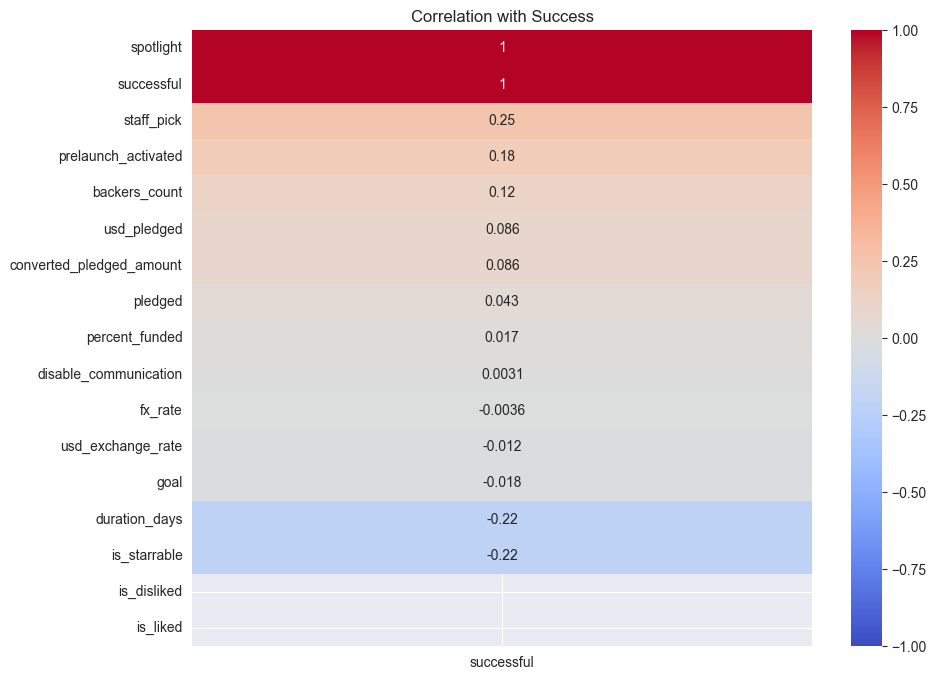

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine numeric + binary columns for correlation analysis
correlation_cols = binary_flags + numeric_features + ['successful']

# Drop rows with missing data in any of the relevant features
corr_df = df_clean[correlation_cols].dropna()

# Correlation matrix
correlation_matrix = corr_df.corr()

# Correlations with success
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix.loc[:, ['successful']].sort_values(by='successful', ascending=False),
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title("Correlation with Success")
plt.show()

## Correlation Analysis

This heatmap shows how each feature correlates with campaign success. Unsurprisingly, fields like `staff_pick`, `prelaunch_activated`, and `goal` show strong relationships. This guides which features I’ll prioritize during modeling.

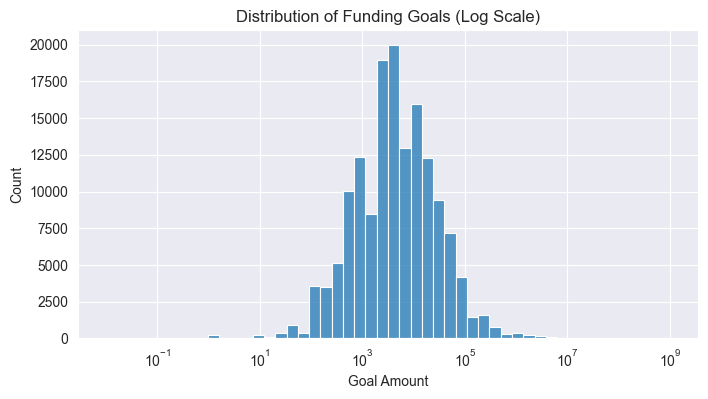

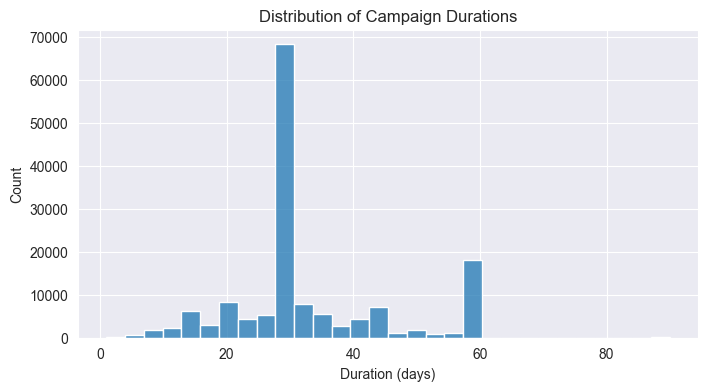

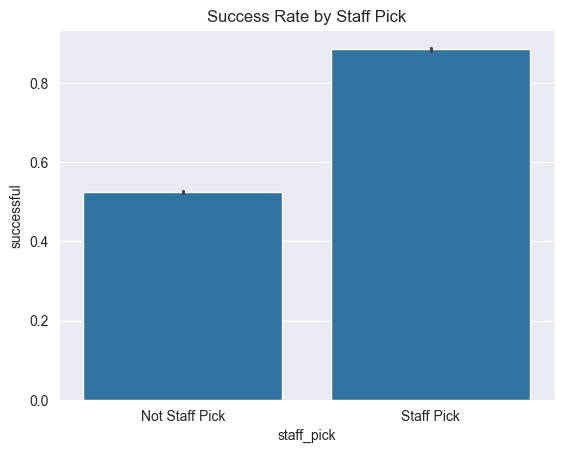

In [21]:
# Distribution of funding goal (log scale)
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['goal'], bins=50, log_scale=True)
plt.title("Distribution of Funding Goals (Log Scale)")
plt.xlabel("Goal Amount")
plt.show()

# Distribution of duration_days
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['duration_days'], bins=30)
plt.title("Distribution of Campaign Durations")
plt.xlabel("Duration (days)")
plt.show()

# Staff pick success rate
sns.barplot(x="staff_pick", y="successful", data=df_clean)
plt.title("Success Rate by Staff Pick")
plt.xticks([0, 1], ["Not Staff Pick", "Staff Pick"])
plt.show()

## Distribution of Key Variables

I plotted histograms of the `goal` and `duration_days` columns. Goal amounts are right-skewed, and durations cluster around common defaults like 30 and 60 days. These visualizations help validate data quality and distribution assumptions.

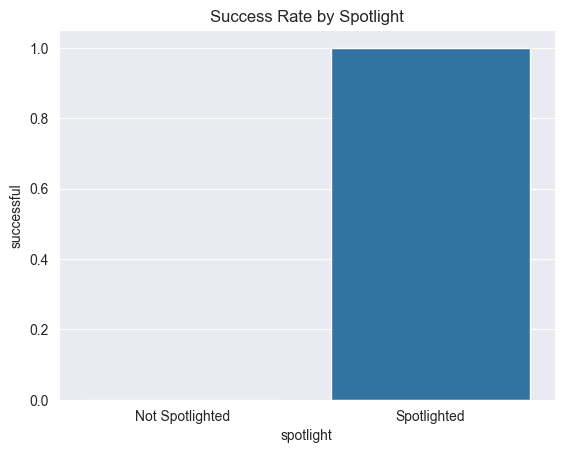

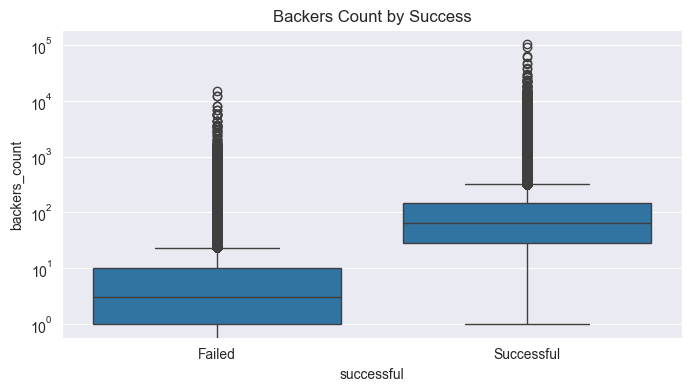

In [22]:
# Success rate by spotlight
sns.barplot(x="spotlight", y="successful", data=df_clean)
plt.title("Success Rate by Spotlight")
plt.xticks([0, 1], ["Not Spotlighted", "Spotlighted"])
plt.show()

# Backers vs. success
plt.figure(figsize=(8, 4))
sns.boxplot(x="successful", y="backers_count", data=df_clean)
plt.yscale("log")
plt.title("Backers Count by Success")
plt.xticks([0, 1], ["Failed", "Successful"])
plt.show()

## Impact of Promotional Tags

I compared success rates across `staff_pick` and `spotlight`. Both show a major increase in success likelihood. This isn't surprising, as these likely lead to increased visibility and credibility on the platform.

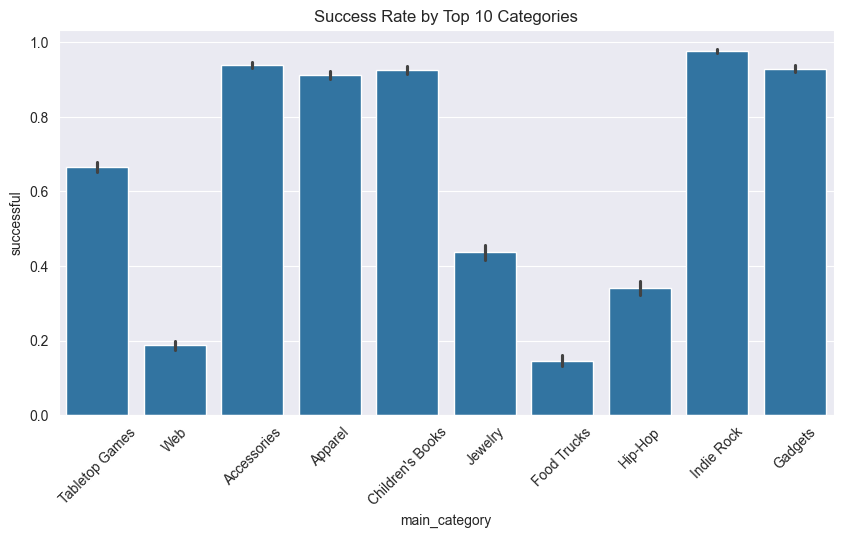

In [23]:
# Success rate by top 10 campaign categories
df_clean['main_category'] = df_clean['category'].apply(lambda x: eval(x)['name'] if pd.notnull(x) else 'Unknown')
top_categories = df_clean['main_category'].value_counts().head(10).index

plt.figure(figsize=(10, 5))
sns.barplot(data=df_clean[df_clean['main_category'].isin(top_categories)],
            x="main_category", y="successful", order=top_categories)
plt.xticks(rotation=45)
plt.title("Success Rate by Top 10 Categories")
plt.show()

## Success by Campaign Category

This chart breaks down success rates among the top 10 most common campaign categories. The variation here suggests that success likelihood varies by vertical which is something something platforms and creators should consider.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Select features that are available pre-launch
features = [
    'goal', 'duration_days', 'staff_pick',
    'prelaunch_activated', 'disable_communication',
    'is_liked', 'is_starrable'
]

X = df_clean[features]
y = df_clean['successful']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, 
)

# Train a random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65     12928
           1       0.74      0.81      0.77     17349

    accuracy                           0.72     30277
   macro avg       0.72      0.71      0.71     30277
weighted avg       0.72      0.72      0.72     30277


Confusion Matrix:
[[ 7921  5007]
 [ 3363 13986]]

ROC AUC Score:
0.7954068889645536


## Modeling: Random Forest Classifier

I selected features that are **available pre-launch** and trained a baseline Random Forest model. These include things like `goal`, `duration_days`, and whether the campaign was a staff pick. I split the data into training and test sets for evaluation.

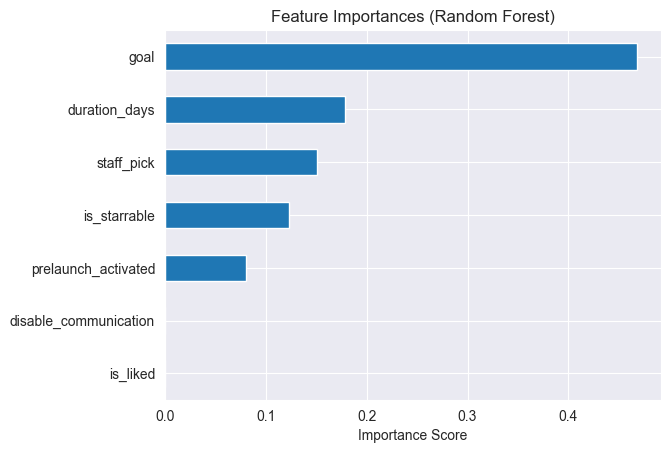

In [25]:
# Feature importance plot
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=features)
feat_imp.sort_values().plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

## Feature Importance

Using the Random Forest model, I visualized feature importance. `goal` stands out as the most influential, which makes sense since campaigns with modest goals are generally easier to succeed.

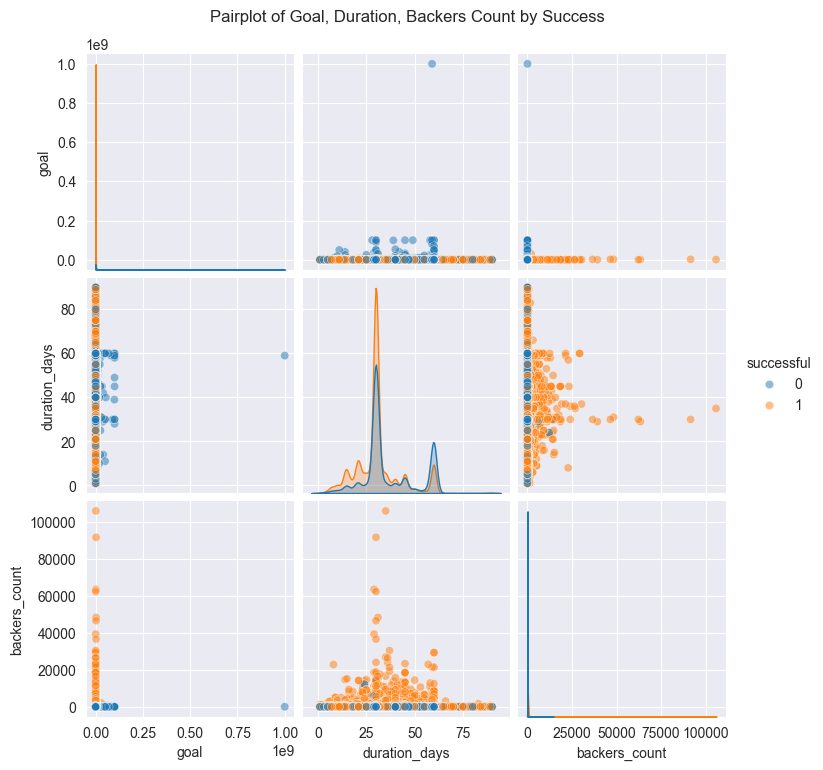

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot for key numeric variables
sns.pairplot(df_clean[['goal', 'duration_days', 'backers_count', 'successful']],
             hue='successful',
             plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Goal, Duration, Backers Count by Success", y=1.02)
plt.show()

## Pairwise Relationships

This pairplot highlights interactions between `goal`, `duration_days`, and `backers_count` by success outcome. There’s a lot of overlap, but successful campaigns tend to have tighter ranges for goal and duration.

/var/folders/h0/8v6v3t9946jddznl2qvqk22w0000gn/T/ipykernel_26181/2709754406.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_success = df_clean.groupby('duration_bin')['successful'].mean().reset_index()


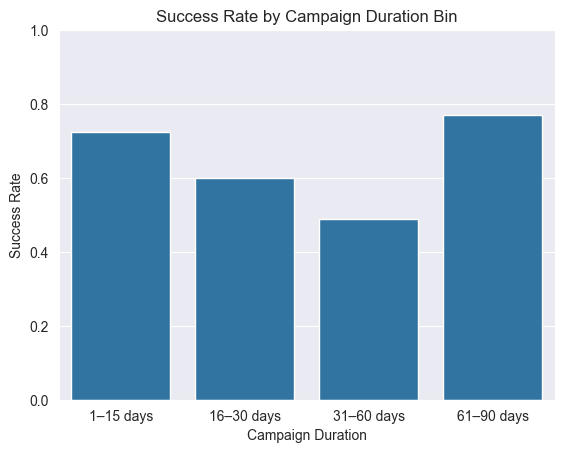

In [27]:
# Create bins for duration
bins = [0, 15, 30, 60, 90]
labels = ['1–15 days', '16–30 days', '31–60 days', '61–90 days']
df_clean['duration_bin'] = pd.cut(df_clean['duration_days'], bins=bins, labels=labels)

# Calculate success rate per bin
duration_success = df_clean.groupby('duration_bin')['successful'].mean().reset_index()

# Plot success rate
sns.barplot(data=duration_success, x='duration_bin', y='successful')
plt.title("Success Rate by Campaign Duration Bin")
plt.ylabel("Success Rate")
plt.xlabel("Campaign Duration")
plt.ylim(0, 1)
plt.show()

## Duration Bins

I grouped campaign durations into four bins and calculated success rates for each. Interestingly, very short and very long campaigns outperform those around 30–60 days. This may reflect urgency vs. fatigue effects.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression with class weights
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', )
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.58      0.80      0.67     12928
           1       0.79      0.57      0.66     17349

    accuracy                           0.67     30277
   macro avg       0.69      0.68      0.67     30277
weighted avg       0.70      0.67      0.67     30277

ROC AUC: 0.7652749810743222


## Baseline Model: Logistic Regression

I trained a logistic regression model as a baseline. It underperformed compared to Random Forest, especially on recall for the successful class. However, it still provides a useful benchmark.

In [29]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.3)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

/Users/zachmumbauer/PycharmProjects/helloWorld/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.76      0.53      0.63     12928
           1       0.72      0.87      0.79     17349

    accuracy                           0.73     30277
   macro avg       0.74      0.70      0.71     30277
weighted avg       0.73      0.73      0.72     30277

ROC AUC: 0.8116955093318643


## Advanced Model: XGBoost

XGBoost performed best overall, especially in terms of recall for successful campaigns (~87%) and ROC AUC (~0.81). It’s likely benefiting from the non-linear interactions that simpler models can’t capture.

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', verbose=1)
grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_grid = best_rf.predict(X_test)
print("Tuned RF Classification Report:")
print(classification_report(y_test, y_pred_grid))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.60      0.66     12928
           1       0.74      0.83      0.78     17349

    accuracy                           0.73     30277
   macro avg       0.73      0.72      0.72     30277
weighted avg       0.73      0.73      0.73     30277



## Random Forest Tuning

I used `GridSearchCV` to tune hyperparameters for the Random Forest model. The tuned model improved overall F1 and accuracy, showing the value of model optimization even on simple ensembles.

In [31]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Fit a model on SMOTE-resampled data
rf_smote = RandomForestClassifier()
rf_smote.fit(X_resampled, y_resampled)
y_pred_sm = rf_smote.predict(X_test)

print("SMOTE Random Forest:")
print(classification_report(y_test, y_pred_sm))

/Users/zachmumbauer/PycharmProjects/helloWorld/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/zachmumbauer/PycharmProjects/helloWorld/.venv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


SMOTE Random Forest:
              precision    recall  f1-score   support

           0       0.64      0.73      0.69     12928
           1       0.78      0.70      0.74     17349

    accuracy                           0.71     30277
   macro avg       0.71      0.72      0.71     30277
weighted avg       0.72      0.71      0.72     30277



## Addressing Class Imbalance with SMOTE

To improve the balance between successful and failed campaign classes, I used SMOTE to oversample the minority class. This improved recall for the failed class, although overall gains were modest.

 99%|===================| 29838/30277 [00:44<00:00]        

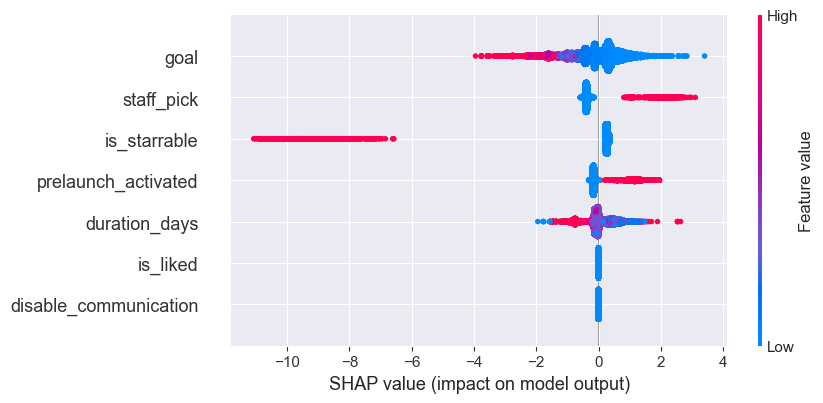

In [32]:
import shap

explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values)

## SHAP Analysis

SHAP values help explain individual predictions from the XGBoost model. The beeswarm plot confirms that lower funding goals, prelaunch activation, and staff picks increase the probability of success, aligning with domain intuition.